In [1]:
import pandas as pd

In [2]:
pd.__version__

'2.2.3'

In [3]:
!pip install pyarrow

In [2]:
import sklearn
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
import os
import pickle

In [4]:
sklearn.__version__

'1.6.1'

In [5]:
year = '2023'
months = ['01', '02']
yellow_trip_data = pd.DataFrame()
for month in months:
    url = f'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_{year}-{month}.parquet'
    df = pd.read_parquet(url)
    print(month, len(df.columns))
    df['month'] = f'{year}-{month}'
    yellow_trip_data = pd.concat([yellow_trip_data, df])

01 19
02 19


In [6]:
yellow_trip_data['duration'] = yellow_trip_data.tpep_dropoff_datetime - yellow_trip_data.tpep_pickup_datetime
yellow_trip_data.duration = yellow_trip_data.duration.apply(lambda td: td.total_seconds() / 60)

In [5]:
yellow_trip_data[yellow_trip_data['month']=='2023-01']['duration'].std()

42.594351241920904

In [21]:
len(yellow_trip_data[yellow_trip_data['month']=='2023-01'])

3066766

In [7]:
yellow_filtered = yellow_trip_data[(yellow_trip_data.month=='2023-01') & (yellow_trip_data.duration >= 1) & (yellow_trip_data.duration <= 60)]
len(yellow_filtered)

3009173

In [24]:
len(yellow_filtered) / len(yellow_trip_data[yellow_trip_data['month']=='2023-01'])

0.9812202822125979

In [25]:
len(yellow_trip_data[(yellow_trip_data.duration >= 1) & (yellow_trip_data.duration <= 60)]) / len(yellow_trip_data)

0.9806717283752243

In [7]:
categorical = ['PULocationID', 'DOLocationID']
yellow_trip_data[categorical] = yellow_trip_data[categorical].astype(str)

In [7]:
train_data = yellow_trip_data[(yellow_trip_data.month=='2023-01') & (yellow_trip_data.duration >= 1) & (yellow_trip_data.duration <= 60)]
train_dicts = train_data[categorical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

print(len(dv.get_feature_names_out()))

target = 'duration'
y_train = train_data[target].values
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

root_mean_squared_error(y_train, y_pred)

515


7.649262443101424

In [12]:
file_path = 'models/lin_reg.bin'
os.makedirs(os.path.dirname(file_path), exist_ok=True)
with open(file_path, 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [8]:
file_path = 'models/lin_reg.bin'
with open(file_path, 'rb') as f_in:
    (dv, lr) = pickle.load(f_in)

In [9]:
val_data = yellow_trip_data[(yellow_trip_data.month=='2023-02') & (yellow_trip_data.duration >= 1) & (yellow_trip_data.duration <= 60)]
val_dicts = val_data[categorical].to_dict(orient='records')
X_val = dv.transform(val_dicts)
target = 'duration'
y_val = val_data[target].values


In [10]:

y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred)

7.811813318594438

Shape parameter: 1.4275681979522923
Scale parameter: 16.144957072184418


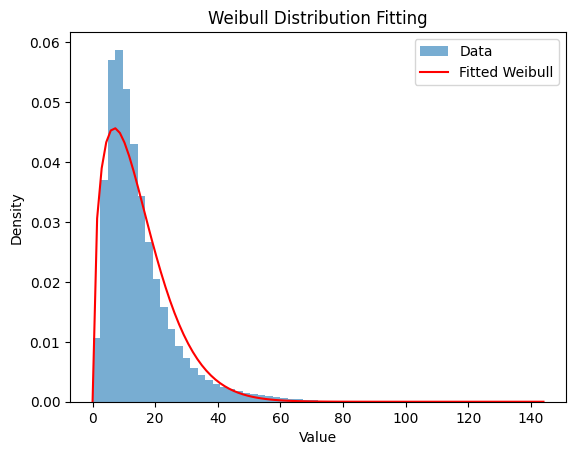

In [11]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt

# Sample data (replace with your actual data)
data = yellow_trip_data[(yellow_trip_data.duration > 0) & (yellow_trip_data.duration <= 120)]['duration']

# Fit the Weibull distribution
shape, loc, scale = st.weibull_min.fit(data, floc=0)

# Print the fitted parameters
print("Shape parameter:", shape)
print("Scale parameter:", scale)

# Generate x values for plotting the PDF
x = np.linspace(0, max(data) * 1.2, 100)

# Plot the histogram of the data and the fitted PDF
plt.hist(data, bins=50, density=True, alpha=0.6, label='Data')
plt.plot(x, st.weibull_min.pdf(x, shape, loc, scale), 'r-', label='Fitted Weibull')
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Weibull Distribution Fitting')
plt.legend()
plt.show()